# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

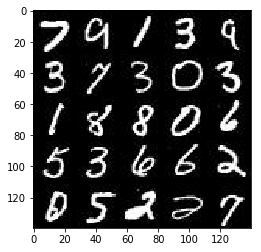

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

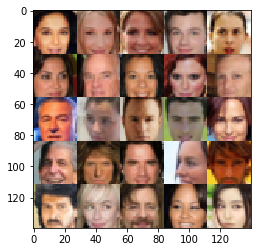

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Helpers

I wrote these to remove the deplicated code from all over the place and reduce copy-paste errors

In [6]:
def lrelu(tensor, alpha=0.2):
    """Calculate a leaky ReLU with the supplied tensor and alpha"""
    return tf.maximum(tensor, tensor * alpha)

In [7]:
def conv2d_leaky(inputs, outputs, kernel_size=5, strides=2, padding='same', alpha=0.2):
    layer = tf.layers.conv2d(inputs, outputs, kernel_size, strides, padding)
    return lrelu(layer, alpha) if alpha != -1 else layer

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [19]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    drop_rate = 0.1

    # image shape: batch_count, 28, 28, 3
    with tf.variable_scope('discriminator', reuse=reuse):
        
        conv0 = conv2d_leaky(images, 32, strides=1, padding='same')
        conv0 = tf.layers.dropout(conv0, drop_rate)
        
        conv1 = conv2d_leaky(images, 64, strides=2, padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=False)
        conv1 = tf.layers.dropout(conv1, drop_rate)
        # now 14x14x64

        conv2 = conv2d_leaky(conv1, 128)
        conv2 = tf.layers.batch_normalization(conv2, training=False)
        conv2 = tf.layers.dropout(conv2, drop_rate)
        # now 7x7x128
                
        conv3 = conv2d_leaky(conv2, 256, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=False)
        conv3 = tf.layers.dropout(conv3, drop_rate)
        # now 4x4x256
        
        conv4 = conv2d_leaky(conv3, 512, strides=1, padding='same')
        conv4 = tf.layers.batch_normalization(conv4, training=False)
        conv4 = tf.layers.dropout(conv4, drop_rate)
        
        
        flat = tf.reshape(conv4, (-1, 2 * 2 * 512))
        
        logits = tf.layers.dense(flat, 1)
        out = tf.nn.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [20]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    drop_rate = 0.1
    # why the opposite???
    with tf.variable_scope('generator', reuse=not is_train):

        x1 = tf.layers.dense(z, 7 * 7 * 512,
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                             bias_initializer=tf.contrib.layers.xavier_initializer())
        

        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = lrelu(x1)
        # 7x7x512 now

        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                        bias_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = lrelu(x2)
        x2 = tf.layers.dropout(x2, drop_rate, training=is_train)
        # 14x14x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                        bias_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = lrelu(x3)
        x3 = tf.layers.dropout(x3, drop_rate, training=is_train)
        # 28x28x128 now
        
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                        bias_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = lrelu(x4)
        x4 = tf.layers.dropout(x4, drop_rate, training=is_train)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                            bias_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # encapsulate the repeated logic
    def model_loss(logits, like_shape_for_labels, smoothing=1):
        return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=like_shape_for_labels))
    
    smoothing = 0.9 # factor to help with generalization
    
    # now actually calculate those losses
    d_loss_real = model_loss(d_logits_real, tf.ones_like(d_model_real) * smoothing)

    d_loss_fake = model_loss(d_logits_fake, tf.zeros_like(d_model_fake))
    g_loss = model_loss(d_logits_fake, tf.ones_like(d_model_fake))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainables = tf.trainable_variables()
    d_vars = [var for var in trainables if var.name.startswith('discriminator')]
    g_vars = [var for var in trainables if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    print("parameters:")
    print("\t epoch_count =", epoch_count)
    print("\t batch_size =", batch_size)
    print("\t z_dim =", z_dim)
    print("\t learning_rate =", learning_rate)
    print("\t beta1 =", beta1)
    print("\t data_shape =", data_shape)
    print("\t image_mode =", data_image_mode)
    
    data_set_size, width, height, channels = data_shape
    
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    step = 0
    print_every = 20
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Optimizers do their thing
                _ = sess.run(d_opt, feed_dict={ input_z: batch_z, input_real: batch_images, lr: learning_rate })

                # double dip for the Generator, see if it addresses the symptoms
                for _ in range(0, 2):
                    _ = sess.run(g_opt, feed_dict={ input_z: batch_z, input_real: batch_images, lr: learning_rate })
                
                if step % print_every == 0:
                    train_loss_d = d_loss.eval({ input_z: batch_z, input_real: batch_images })
                    train_loss_g = g_loss.eval({ input_z: batch_z })

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Step {}".format(step),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if step % show_every == 0:
                    show_generator_output(sess, 10, input_z, channels, data_image_mode)

    # No return value because we are just churning on the data

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

parameters:
	 epoch_count = 2
	 batch_size = 32
	 z_dim = 100
	 learning_rate = 0.001
	 beta1 = 0.4
	 data_shape = (60000, 28, 28, 1)
	 image_mode = L
Epoch 1/2... Step 20 Discriminator Loss: 1.0401... Generator Loss: 1.5076
Epoch 1/2... Step 40 Discriminator Loss: 1.0900... Generator Loss: 0.9855
Epoch 1/2... Step 60 Discriminator Loss: 1.2749... Generator Loss: 1.2530
Epoch 1/2... Step 80 Discriminator Loss: 0.4445... Generator Loss: 3.2896
Epoch 1/2... Step 100 Discriminator Loss: 1.3593... Generator Loss: 0.6979


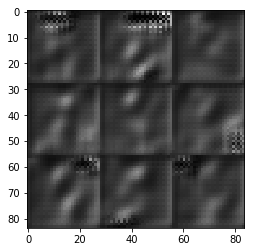

Epoch 1/2... Step 120 Discriminator Loss: 1.4726... Generator Loss: 0.6378
Epoch 1/2... Step 140 Discriminator Loss: 0.7913... Generator Loss: 1.4696
Epoch 1/2... Step 160 Discriminator Loss: 1.5906... Generator Loss: 2.1236
Epoch 1/2... Step 180 Discriminator Loss: 0.7421... Generator Loss: 3.8546
Epoch 1/2... Step 200 Discriminator Loss: 0.6753... Generator Loss: 1.9674


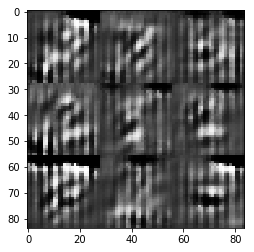

Epoch 1/2... Step 220 Discriminator Loss: 0.8151... Generator Loss: 1.7720
Epoch 1/2... Step 240 Discriminator Loss: 1.2098... Generator Loss: 0.7055
Epoch 1/2... Step 260 Discriminator Loss: 1.1133... Generator Loss: 1.0134
Epoch 1/2... Step 280 Discriminator Loss: 1.2213... Generator Loss: 1.1591
Epoch 1/2... Step 300 Discriminator Loss: 1.1778... Generator Loss: 0.7756


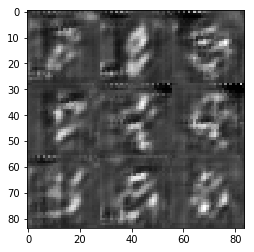

Epoch 1/2... Step 320 Discriminator Loss: 3.1574... Generator Loss: 0.1220
Epoch 1/2... Step 340 Discriminator Loss: 1.7399... Generator Loss: 0.3640
Epoch 1/2... Step 360 Discriminator Loss: 1.2223... Generator Loss: 0.8925
Epoch 1/2... Step 380 Discriminator Loss: 1.3445... Generator Loss: 0.7274
Epoch 1/2... Step 400 Discriminator Loss: 1.3871... Generator Loss: 0.6030


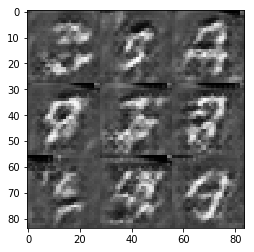

Epoch 1/2... Step 420 Discriminator Loss: 1.1185... Generator Loss: 1.3891
Epoch 1/2... Step 440 Discriminator Loss: 1.1925... Generator Loss: 0.9732
Epoch 1/2... Step 460 Discriminator Loss: 0.6717... Generator Loss: 3.1430
Epoch 1/2... Step 480 Discriminator Loss: 1.7169... Generator Loss: 0.4340
Epoch 1/2... Step 500 Discriminator Loss: 0.9960... Generator Loss: 1.5792


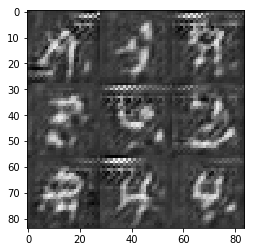

Epoch 1/2... Step 520 Discriminator Loss: 0.9267... Generator Loss: 1.4383
Epoch 1/2... Step 540 Discriminator Loss: 0.8817... Generator Loss: 1.5344
Epoch 1/2... Step 560 Discriminator Loss: 0.8545... Generator Loss: 1.3345
Epoch 1/2... Step 580 Discriminator Loss: 1.4943... Generator Loss: 0.5361
Epoch 1/2... Step 600 Discriminator Loss: 1.2809... Generator Loss: 3.0262


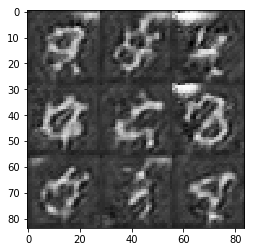

Epoch 1/2... Step 620 Discriminator Loss: 1.0105... Generator Loss: 1.5816
Epoch 1/2... Step 640 Discriminator Loss: 2.1838... Generator Loss: 3.3832
Epoch 1/2... Step 660 Discriminator Loss: 1.0773... Generator Loss: 0.8367
Epoch 1/2... Step 680 Discriminator Loss: 1.1573... Generator Loss: 0.9813
Epoch 1/2... Step 700 Discriminator Loss: 0.9034... Generator Loss: 1.3478


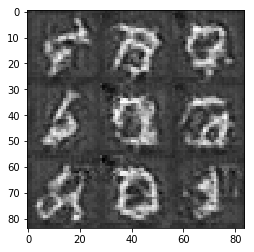

Epoch 1/2... Step 720 Discriminator Loss: 1.2711... Generator Loss: 0.8514
Epoch 1/2... Step 740 Discriminator Loss: 0.8200... Generator Loss: 1.4402
Epoch 1/2... Step 760 Discriminator Loss: 0.7902... Generator Loss: 1.7164
Epoch 1/2... Step 780 Discriminator Loss: 1.1060... Generator Loss: 1.2997
Epoch 1/2... Step 800 Discriminator Loss: 1.1397... Generator Loss: 0.9993


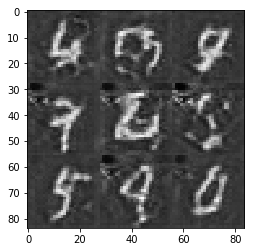

Epoch 1/2... Step 820 Discriminator Loss: 0.8426... Generator Loss: 1.3135
Epoch 1/2... Step 840 Discriminator Loss: 0.7254... Generator Loss: 1.7286
Epoch 1/2... Step 860 Discriminator Loss: 0.6870... Generator Loss: 1.5792
Epoch 1/2... Step 880 Discriminator Loss: 0.7755... Generator Loss: 2.0742
Epoch 1/2... Step 900 Discriminator Loss: 1.0295... Generator Loss: 1.0094


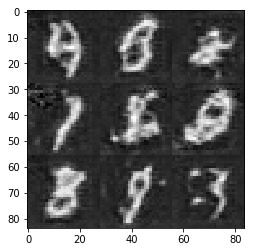

Epoch 1/2... Step 920 Discriminator Loss: 2.5934... Generator Loss: 2.2336
Epoch 1/2... Step 940 Discriminator Loss: 0.5329... Generator Loss: 2.6135
Epoch 1/2... Step 960 Discriminator Loss: 1.1561... Generator Loss: 1.2119
Epoch 1/2... Step 980 Discriminator Loss: 1.1942... Generator Loss: 0.9585
Epoch 1/2... Step 1000 Discriminator Loss: 0.8189... Generator Loss: 1.4380


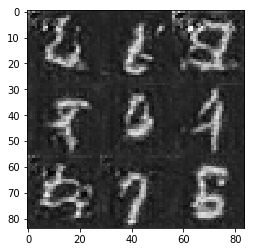

Epoch 1/2... Step 1020 Discriminator Loss: 0.7274... Generator Loss: 1.6196
Epoch 1/2... Step 1040 Discriminator Loss: 0.7869... Generator Loss: 2.1912
Epoch 1/2... Step 1060 Discriminator Loss: 0.7140... Generator Loss: 1.8064
Epoch 1/2... Step 1080 Discriminator Loss: 0.9296... Generator Loss: 1.3382
Epoch 1/2... Step 1100 Discriminator Loss: 1.3834... Generator Loss: 0.7259


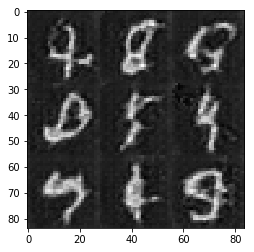

Epoch 1/2... Step 1120 Discriminator Loss: 2.0680... Generator Loss: 2.9605
Epoch 1/2... Step 1140 Discriminator Loss: 1.6346... Generator Loss: 0.6214
Epoch 1/2... Step 1160 Discriminator Loss: 0.8596... Generator Loss: 1.5687
Epoch 1/2... Step 1180 Discriminator Loss: 1.0359... Generator Loss: 1.0167
Epoch 1/2... Step 1200 Discriminator Loss: 0.9162... Generator Loss: 1.1783


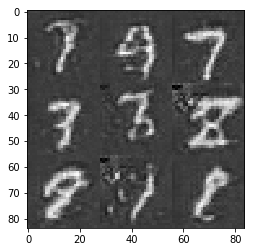

Epoch 1/2... Step 1220 Discriminator Loss: 1.0648... Generator Loss: 1.8755
Epoch 1/2... Step 1240 Discriminator Loss: 0.4505... Generator Loss: 3.4488
Epoch 1/2... Step 1260 Discriminator Loss: 0.9608... Generator Loss: 1.3067
Epoch 1/2... Step 1280 Discriminator Loss: 0.5636... Generator Loss: 3.3444
Epoch 1/2... Step 1300 Discriminator Loss: 1.3310... Generator Loss: 0.7435


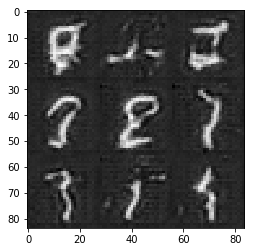

Epoch 1/2... Step 1320 Discriminator Loss: 0.7201... Generator Loss: 1.9772
Epoch 1/2... Step 1340 Discriminator Loss: 0.6042... Generator Loss: 2.7101


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

parameters:
	 epoch_count = 1
	 batch_size = 32
	 z_dim = 100
	 learning_rate = 0.0002
	 beta1 = 0.8
	 data_shape = (202599, 28, 28, 3)
	 image_mode = RGB
Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 1.8802
Epoch 1/1... Discriminator Loss: 0.6608... Generator Loss: 3.7170
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 1.5882
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 2.1183


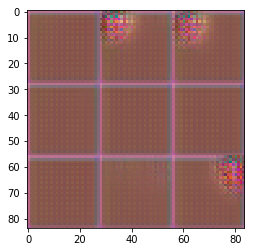

Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 1.5961
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.8788
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.8325


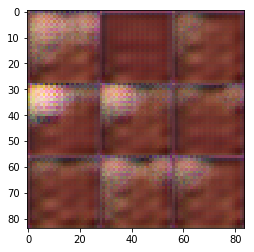

Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 2.1855


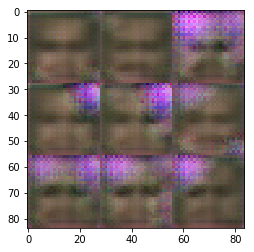

Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 1.3815
Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 2.1424
Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.7264


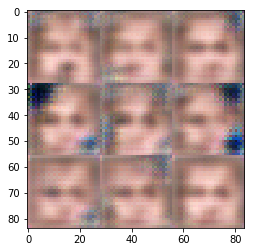

Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 1.0932
Epoch 1/1... Discriminator Loss: 1.5633... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.6137... Generator Loss: 0.7384


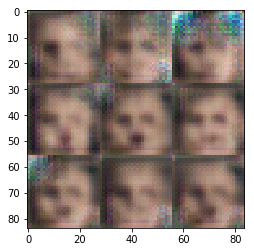

Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7601


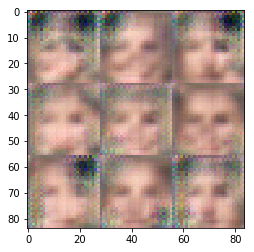

Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.6809


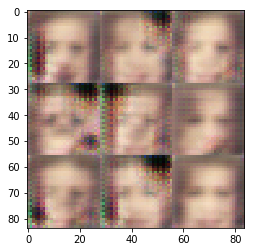

Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.7931


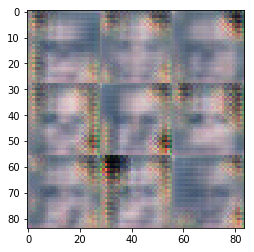

Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7781


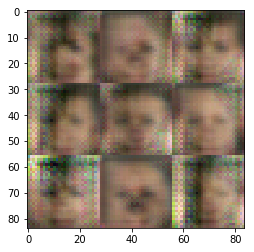

Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.7850


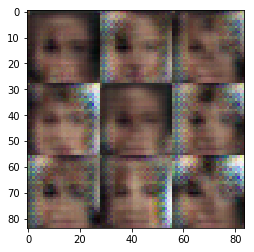

Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7879


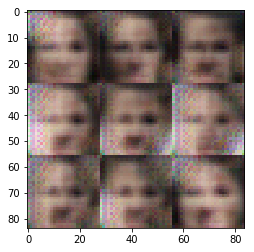

Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.7710


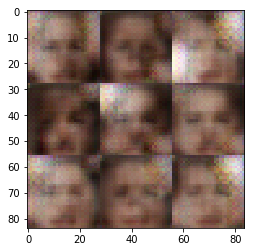

Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.8216


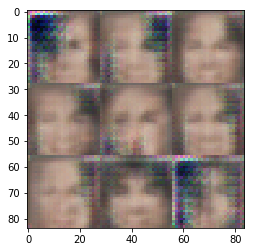

Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.8302


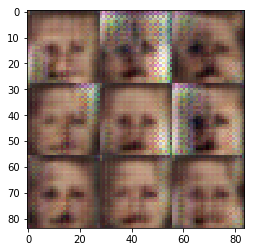

Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7847


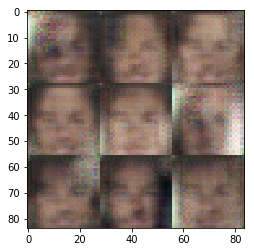

Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7968


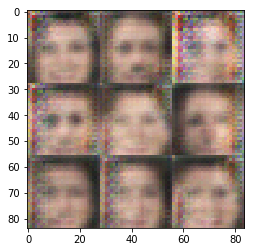

Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7922


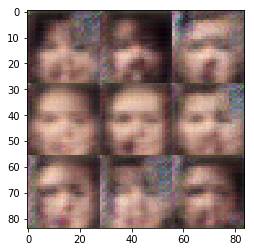

Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7856


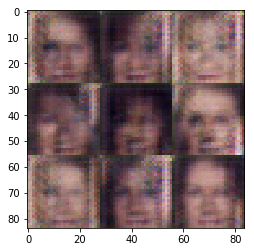

Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7912


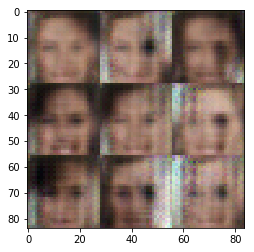

Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7989


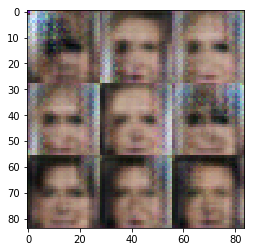

Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7875


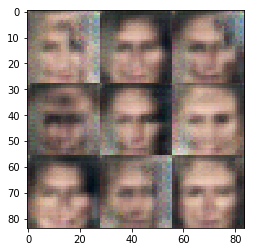

Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.8044


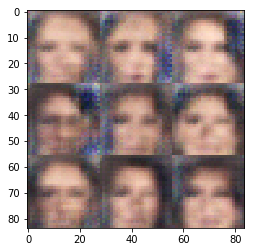

Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.7938


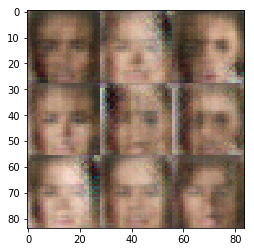

Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7922


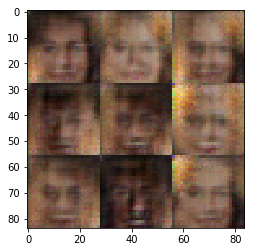

Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.8003


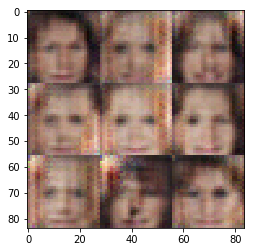

Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.7858


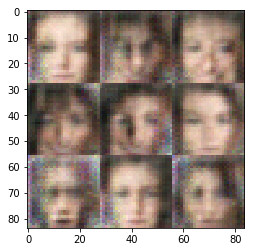

Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7945


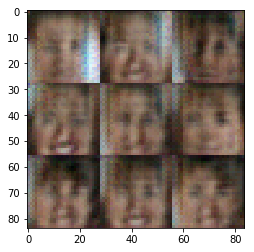

Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.8020


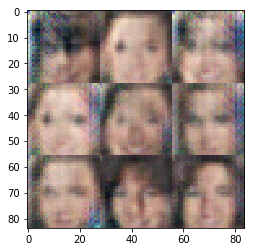

Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.8026


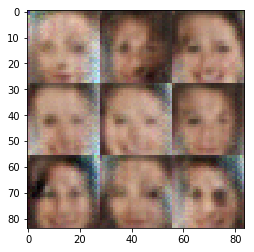

Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7954


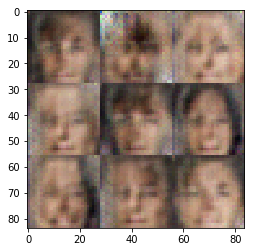

Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7977


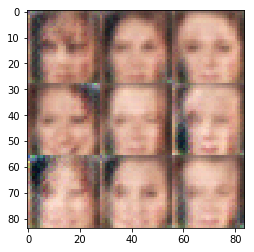

Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7990


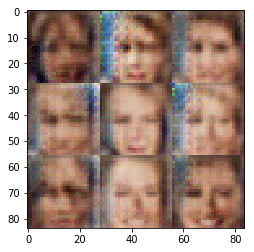

Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7952


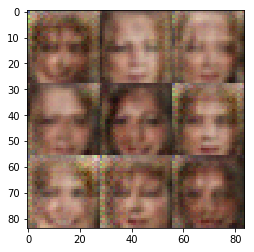

Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.8029


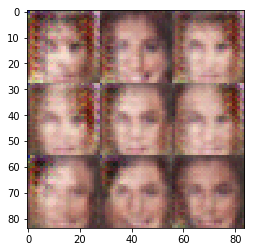

Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7976


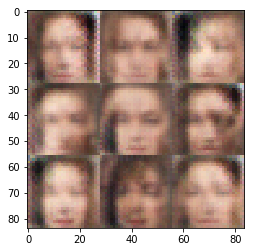

Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7985


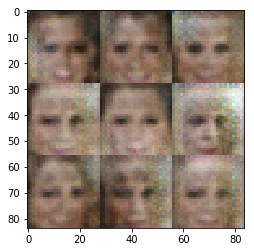

Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7990


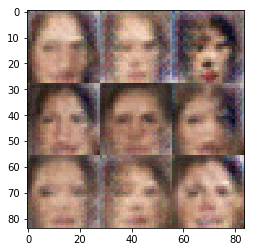

Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7968


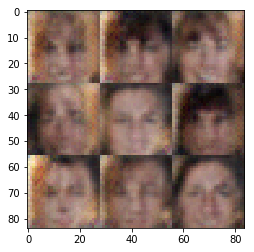

Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.7994


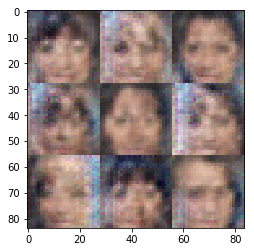

Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7974


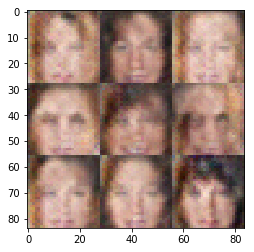

Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7985


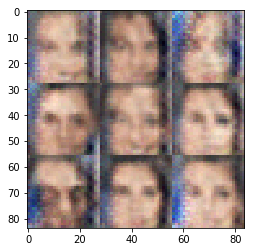

Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.7968


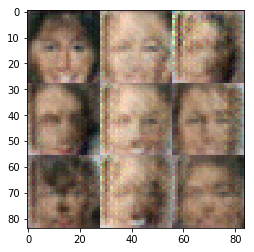

Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7960


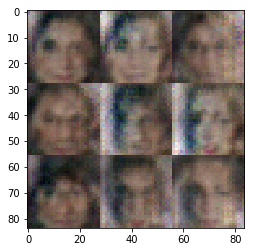

Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7979


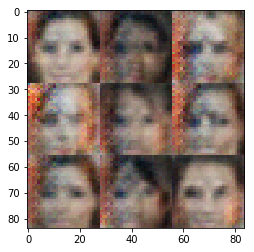

Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7986


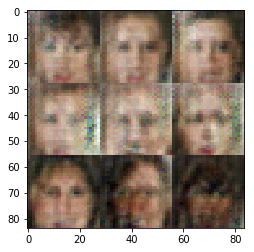

Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7972


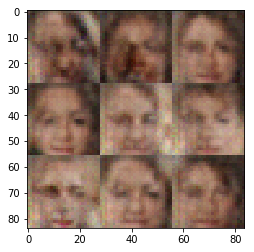

Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7990


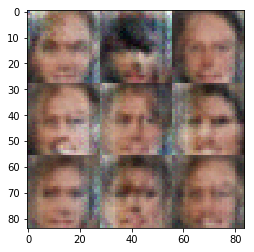

Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7974


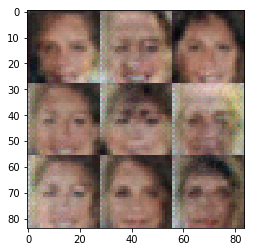

Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7993


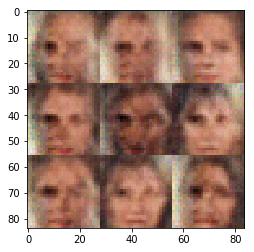

Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7973


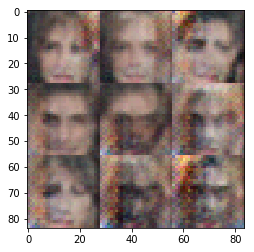

Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7996


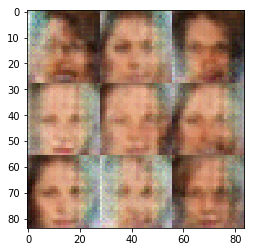

Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7946


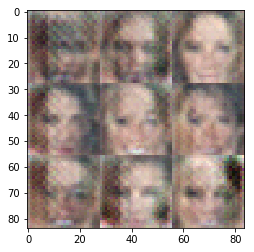

Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7981


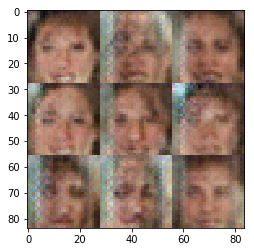

Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7991


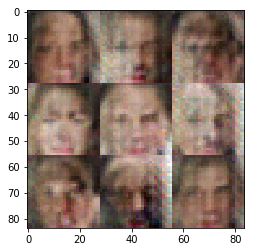

Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7977


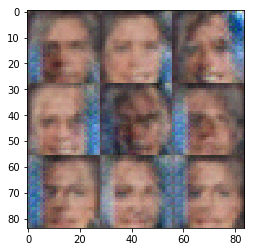

Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7981


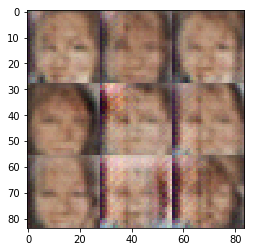

Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7980


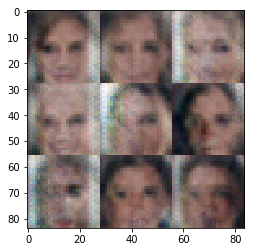

Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.8010


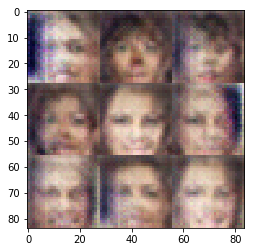

Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7971


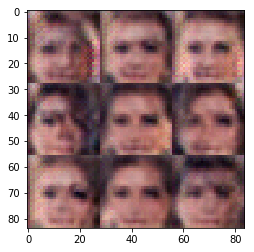

Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 2.2223
Epoch 1/1... Discriminator Loss: 0.7345... Generator Loss: 2.5304
Epoch 1/1... Discriminator Loss: 0.9897... Generator Loss: 2.6213


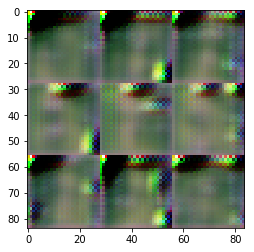

Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 1.9232
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 2.1728
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 1.8949
Epoch 1/1... Discriminator Loss: 0.7828... Generator Loss: 1.9271


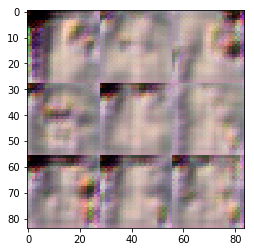

Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 1.3923
Epoch 1/1... Discriminator Loss: 0.8084... Generator Loss: 1.3081


KeyboardInterrupt: 

In [16]:
batch_size = 32 # see slack #project-5
z_dim = 100
learning_rate = 0.0002
beta1 = 0.8


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.